# このファイルについて

衛星の熱設計における熱平衡方程式を解きます。
\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

アルベド項と赤外輻射項が時間変動するので厳しい。。。

頑張って

# Requirement

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

# 関数など

In [2]:
class Thermal_simu():
    """熱平衡方程式をとくクラス。"""
    def __init__(self,capacity_i,C_ij,R_ij,r_satellite):
        """
        初期化
        Parameters:
        capacity_i: ndarray 1-D vector
            節点iでの熱容量
        C_ij: ndarray 2-D vector
            節点i,jの伝熱によるカップリング
        R_ij: ndarray 2-D vector
            節点i,jの輻射によるカップリング
        r_satellite: ndarray 2-D vector
            衛星の軌道半径。太陽輻射とか計算するときに使う。と思う。
        """
        c_i = self.capacity_i
        C_ij = self.C_ij
        R_ij = self.R_ij
        r = r_satellite
        
        P_s = 1358 # 太陽定数
        
        T_i = np.zeros(i) # 最終的に、熱平衡方程式を解いた結果をここに格納したい
    
    def solve_eq(self):
        """
        全部解いてくれる関数だよ。
        """
        return 0
        
    def sun_radiation(self):
        """
        太陽輻射 

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける太陽輻射による熱入力に対応
        """
        q = 0
        return q
    
    def earth_radiation(self):
        """
        地球の赤外輻射

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球の赤外輻射による熱入力に対応
        """
        q = 0
        return q
    
    def albedo(self):
        """
        地球のアルベド

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球のアルベドによる熱入力に対応
        """
        q = 0
        return q

In [3]:
class Easy_Thermal_simu():
    """熱平衡方程式をとくクラス。"""
    def __init__(self,A_i,alpha_i,eps_i):
        self.A = A_i
        self.alpha = alpha_i
        self.eps = eps_i
        self.P_s = 1358 # 太陽定数
        self.P_e = 237
        self.T = 0 # 最終的に、熱平衡方程式を解いた結果をここに格納したい
        self.Q_inner = 0
        self.sigma = 5.67*10**(-8)
    
    def solve_eq(self):
        """
        全部解いてくれる関数だよ。
        """
        Q_out_by_T4 = 0
        for i in range(len(self.A)):
            Q_out_by_T4 += self.A[i] * self.eps[i] * self.sigma
        Q_in = self.get_sun_radiation() + self.get_earth_radiation() + self.get_albedo() + self.Q_inner
        self.T = (Q_in/Q_out_by_T4)**0.25
        
    def get_sun_radiation(self):
        """
        太陽輻射 

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける太陽輻射による熱入力に対応
        """
        q = self.P_s * self.A[0] * self.alpha[0] * 1
        return q
    
    def get_earth_radiation(self):
        """
        地球の赤外輻射

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球の赤外輻射による熱入力に対応
        """
        q = self.P_e * self.A[5] * self.eps[5] * 1 
        return q
    
    def get_albedo(self):
        """
        地球のアルベド

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球のアルベドによる熱入力に対応
        """
        q = self.P_s * 0.3 * self.A[5] * self.alpha[5] * 1
        return q
    
    def set_Q_inner(self,q):
        self.Q_inner = q

In [4]:
alpha = [0.2,0.2,0.2,0.2,0.2,0.2]
eps = [0.8,0.8,0.8,0.8,0.8,0.8]
A = [1,1,1,1,1,1]

sim = Easy_Thermal_simu(A,alpha,eps)
sim.set_Q_inner(500)
sim.solve_eq()
sim.T

248.7892934630962

# 熱平衡方程式クラス

\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

In [314]:
class Thermal_eq:
    sigma = 5.670367e-8 #  Stefan–Boltzmann Constant

    def __init__(self,n_nodes,n_steps,dt):
        self.n_nodes = n_nodes
        self.n_steps = n_steps
        self.dt = dt
        
        self.t = np.arange(0,dt*n_steps,n_steps)              # 時間
        
        self.m = [1. for i in range(n_nodes)]                  # 質量
        self.c = [1. for i in range(n_nodes)]                  # 熱容量
        self.C = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # c[i,j]
        self.R = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # R[i,j]
        self.T_all = [[1. for i in range(n_nodes)] for j in range(n_steps)]    # 温度（横に時間軸）
        
        self.Q_in = [[0. for i in range(n_nodes)] for j in range(n_steps)]
        
    def set_params(self,param_m=None,param_C=None,param_c=None,param_R=None):
        if not param_m==None:
            assert len(param_m)==self.n_nodes, 'size of parameter m is different'
            self.m = param_m
        if not param_C==None:
            assert len(param_C)==self.n_nodes, 'size of parameter C is different'
            self.C = param_C
        if not param_c==None:
            assert len(param_c)==self.n_nodes, 'size of parameter c is different'
            self.c = param_c
        if not param_R==None:
            assert len(param_R)==self.n_nodes, 'size of parameter R is different'
            self.R = param_R
            
    def set_Q_in(self,n_node,Q_t):
        self.Q_in[n_node-1] = Q_t
    
    def solve_eq(self,T_init):
        self.T_all[0] = T_init
        for i in range(self.n_steps-1):
            if i%100==0:
                print('now at {0} step'.format(i))
            T_temp = self.T_all[i]
            k0 = self.get_dTdt(i,T_temp)
            k1 = self.get_dTdt(i,[T_temp[i] + k0[i]*self.dt/2 for i in range(self.n_nodes)])
            k2 = self.get_dTdt(i,[T_temp[i] + k1[i]*self.dt/2 for i in range(self.n_nodes)])
            k3 = self.get_dTdt(i,[T_temp[i] + k2[i]*self.dt for i in range(self.n_nodes)])
            k = [(k0[i] + 2*k1[i] + 2*k2[i] + k3[i])/6.0 for i in range(self.n_nodes)]
            self.T_all[i+1] = [T_temp[i] + k[i]*self.dt for i in range(self.n_nodes)]
    
    def get_dTdt(self,n_step,T):
        dTdt = [0 for i in range(self.n_nodes)]
        for i in range(self.n_nodes):
            sum_1 = sum([self.C[i][j]*(T[j]-T[i]) for j in range(self.n_nodes)])
            sum_2 = self.sigma * sum([self.R[i][j]*(T[j]**4-T[i]**4) for j in range(self.n_nodes)])
            dTdt[i] = (sum_1 + sum_2 + self.Q_in[i][n_step]) / self.m[i] / self.c[i]
        return dTdt

# 熱入力計算

In [136]:
Ps = 1358
Pe = 237
Pa = Ps*0.3

In [76]:
def is_even(num):
    if num % 2 == 0:
        return True
    else:
        return False

In [94]:
def get_Q1(n_steps,dt,A,alpha,eps):
    Q_s = [alpha[0]*A[0]*1*Ps if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.sin(2*math.pi*i*dt/T_rev)*Pe if not is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q1 = [Q_s[i] + Q_e[i] for i in range(n_steps)]
    return Q1

In [126]:
def get_Q2(n_steps,dt,A,alpha,eps):
    Q_a = [-alpha[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pa if (i*dt*2//(T_rev/2))%4==1 else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pe if (i*dt*2//(T_rev/2))%4==2 else 0 for i in range(n_steps)]
    Q2 = [Q_a[i] + Q_e[i] for i in range(n_steps)]
    return Q2

In [130]:
def get_Q3(n_steps,dt,A,alpha,eps):
    return [0 for i in range(n_steps)]

In [134]:
def get_Q4(n_steps,dt,A,alpha,eps):
    Q_a = [alpha[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pa if (i*dt*2//(T_rev/2))%4==0 else 0 for i in range(n_steps)]
    Q_e = [eps[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pe if (i*dt*2//(T_rev/2))%4==3 else 0 for i in range(n_steps)]
    Q4 = [Q_a[i] + Q_e[i] for i in range(n_steps)]
    return Q4

In [133]:
def get_Q5(n_steps,dt,A,alpha,eps):
    return [0 for i in range(n_steps)]

In [102]:
def get_Q6(n_steps,dt,A,alpha,eps):
    Q_albedo = [alpha[5]*A[5]*math.sin(2*math.pi*i*dt/T_rev)*Pa if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.sin(2*math.pi*i*dt/T_rev)*Pe if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q6 = [Q_albedo[i] + Q_e[i] for i in range(n_steps)]
    return Q6

# 最悪の場合を計算

In [241]:
def get_F_12(x,y):
    term1 = math.log(((1+x**2)*(1+y**2)/(1+x**2+y**2))**0.5)
    term2 = y*math.sqrt(1+x**2)*math.atan(y/math.sqrt(1+x**2))
    term3 = x*math.sqrt(1+y**2)*math.atan(x/math.sqrt(1+y**2))
    term4 = -y*math.atan(y)-x*math.atan(x)
    return (term1 + term2 + term3 + term4)/(math.pi*x*y/2)

def get_F_16(x,y):
    term1 = math.log((1+x**2)*(1+y**2)/(1+x**2+y**2))
    term2 = x**2*math.log(x**2*(1+x**2+y**2)/(1+x**2)/(x**2+y**2))
    term3 = y**2*math.log(y**2*(1+x**2+y**2)/(1+y**2)/(x**2+y**2))
    term4 = 4*x*math.atan(1/x) + 4*y*math.atan(1/y)
    term5 = -4*math.sqrt(x**2+y**2)*math.atan(1/math.sqrt(x**2+y**2))
    return (term1 + term2 + term3 + term4 + term5)/(math.pi*4*y)

In [307]:
### 基本定数 ###
G = 6.67e-11
r_e = 6378 #地球の半径[km]
M_e = 5.9724e24

### ミッション定数 ###
a = 2.
b = 2.
c = 2.
A = [b*c,c*a,a*b,c*a,a*b,b*c]
alpha = [0.8,0.8,0.8,0.8,0.8,0.8]
eps = [0.2,0.2,0.2,0.2,0.2,0.2]

n_nodes = 6
m_i = [200 for i in range(n_nodes)]
c_i = [0.8 for i in range(n_nodes)]
C_ij = [[0 for i in range(n_nodes)] for j in range(n_nodes)]
R_12 = get_F_12(1,1)
R_16 = get_F_16(1,1)
R_ij = [[0.,R_12,R_12,R_12,R_12,R_16],
     [R_12,0.,R_12,R_16,R_12,R_12],
     [R_12,R_12,0.,R_12,R_16,R_12],
     [R_12,R_16,R_12,0.,R_12,R_12],
     [R_12,R_12,R_16,R_12,0.,R_12],
     [R_16,R_12,R_12,R_12,R_12,0.]]

r = 1200 + r_e
T_rev = 2*math.pi*math.sqrt((r*10**3)**3/G/M_e)

In [317]:
### 計算用の定数決定 ###
dt = 0.5
n_steps = 400

In [318]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(1,get_Q1(n_steps,dt,A,alpha,eps))
eq.set_Q_in(2,get_Q2(n_steps,dt,A,alpha,eps))
eq.set_Q_in(3,get_Q3(n_steps,dt,A,alpha,eps))
eq.set_Q_in(4,get_Q4(n_steps,dt,A,alpha,eps))
eq.set_Q_in(5,get_Q5(n_steps,dt,A,alpha,eps))
eq.set_Q_in(6,get_Q6(n_steps,dt,A,alpha,eps))

In [319]:
T_init = [260.,250.,250.,250.,250.,250.]
eq.solve_eq(T_init)

now at 0 step
now at 100 step
now at 200 step
now at 300 step


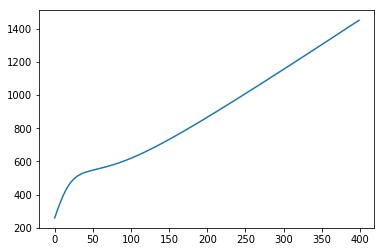

In [320]:
T = np.array(eq.T_all)
plt.plot(T[:,0])